In [134]:
pip install pandas numpy matplotlib scikit-learn xgboost tensorflow

DEPRECATION: Loading egg at /opt/venv/lib/python3.11/site-packages/cvxopt-0.0.0-py3.11-linux-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
Note: you may need to restart the kernel to use updated packages.


In [136]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [137]:
# Load datasets
games_df = pd.read_csv("aima-data/games.csv")
teams_df = pd.read_csv("aima-data/teams.csv")

# Preview Data
print("Initial Data Preview (games_df):")
print(games_df.head())

print("\nTeams Data (teams_df):")
print(teams_df.head())

Initial Data Preview (games_df):
  GAME_DATE_EST   GAME_ID GAME_STATUS_TEXT  HOME_TEAM_ID  VISITOR_TEAM_ID  \
0    2022-12-22  22200477            Final    1610612740       1610612759   
1    2022-12-22  22200478            Final    1610612762       1610612764   
2    2022-12-21  22200466            Final    1610612739       1610612749   
3    2022-12-21  22200467            Final    1610612755       1610612765   
4    2022-12-21  22200468            Final    1610612737       1610612741   

   SEASON  TEAM_ID_home  PTS_home  FG_PCT_home  FT_PCT_home  ...  AST_home  \
0    2022    1610612740     126.0        0.484        0.926  ...      25.0   
1    2022    1610612762     120.0        0.488        0.952  ...      16.0   
2    2022    1610612739     114.0        0.482        0.786  ...      22.0   
3    2022    1610612755     113.0        0.441        0.909  ...      27.0   
4    2022    1610612737     108.0        0.429        1.000  ...      22.0   

   REB_home  TEAM_ID_away  PTS_away

In [139]:
# Data Cleaning
# Drop unnecessary columns
games_df = games_df.drop(columns=["GAME_ID", "GAME_STATUS_TEXT"])

# Convert GAME_DATE_EST to numerical format
games_df["GAME_DATE_EST"] = pd.to_datetime(games_df["GAME_DATE_EST"])
games_df["GAME_DATE_EST"] = (games_df["GAME_DATE_EST"] - games_df["GAME_DATE_EST"].min()).dt.days

# Handle missing values
games_df = games_df.fillna(games_df.median(numeric_only=True))

# Feature Engineering: Performance Metrics
games_df["AST_diff"] = games_df["AST_home"] - games_df["AST_away"]
games_df["REB_diff"] = games_df["REB_home"] - games_df["REB_away"]

# Advanced Metrics (Win Shares, Player Efficiency)
games_df["WIN_SHARES_HOME"] = games_df["AST_home"] * games_df["REB_home"] / (games_df["PTS_home"] + 1)
games_df["WIN_SHARES_AWAY"] = games_df["AST_away"] * games_df["REB_away"] / (games_df["PTS_away"] + 1)

games_df["EFFICIENCY_HOME"] = (games_df["PTS_home"] + games_df["REB_home"] + games_df["AST_home"]) / 3
games_df["EFFICIENCY_AWAY"] = (games_df["PTS_away"] + games_df["REB_away"] + games_df["AST_away"]) / 3

# Game Context Features
games_df["BACK_TO_BACK"] = (games_df["GAME_DATE_EST"].diff() == 1).astype(int)

# Normalize Continuous Features
scaler = MinMaxScaler()
continuous_features = ["AST_home", "REB_home", "AST_away", "REB_away", "AST_diff", "REB_diff",
                       "WIN_SHARES_HOME", "WIN_SHARES_AWAY", "EFFICIENCY_HOME", "EFFICIENCY_AWAY"]

games_df[continuous_features] = scaler.fit_transform(games_df[continuous_features])

# Encode Categorical Variables
games_df["HOME_TEAM_ID"] = games_df["HOME_TEAM_ID"].astype("category").cat.codes
games_df["VISITOR_TEAM_ID"] = games_df["VISITOR_TEAM_ID"].astype("category").cat.codes

# Splitting Data
X = games_df.drop(columns=["HOME_TEAM_WINS", "PTS_home", "PTS_away"])
y = games_df["HOME_TEAM_WINS"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

print("Cleaned Data Preview:")
print(games_df.head())


Cleaned Data Preview:
   GAME_DATE_EST  HOME_TEAM_ID  VISITOR_TEAM_ID  SEASON  TEAM_ID_home  \
0           7018             3               22    2022    1610612740   
1           7018            25               27    2022    1610612762   
2           7017             2               12    2022    1610612739   
3           7017            18               28    2022    1610612755   
4           7017             0                4    2022    1610612737   

   PTS_home  FG_PCT_home  FT_PCT_home  FG3_PCT_home  AST_home  ...  AST_away  \
0     126.0        0.484        0.926         0.382  0.431818  ...  0.452381   
1     120.0        0.488        0.952         0.457  0.227273  ...  0.380952   
2     114.0        0.482        0.786         0.313  0.363636  ...  0.380952   
3     113.0        0.441        0.909         0.297  0.477273  ...  0.261905   
4     108.0        0.429        1.000         0.378  0.363636  ...  0.380952   

   REB_away  HOME_TEAM_WINS  AST_diff  REB_diff  WIN_SHARE

In [140]:
# Define ML Models
log_reg = LogisticRegression(random_state=42)
decision_tree = DecisionTreeClassifier(max_depth=10, random_state=42)
gradient_boost = GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, random_state=42)
random_forest = RandomForestClassifier(n_estimators=300, max_depth=20, min_samples_split=5, random_state=42)
xgboost = XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=10, random_state=42)

# Hyperparameter Tuning (Random Forest)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_
print("Best RF Parameters:", grid_search.best_params_)

# Voting Classifier
voting_model = VotingClassifier(
    estimators=[('lr', log_reg), ('dt', decision_tree), ('gb', gradient_boost), ('rf', best_rf), ("xgb", xgboost)],
    voting='hard'
)

Best RF Parameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}


In [141]:
# Train ML Model
voting_model.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('dt',
                              DecisionTreeClassifier(max_depth=10,
                                                     random_state=42)),
                             ('gb',
                              GradientBoostingClassifier(learning_rate=0.05,
                                                         n_estimators=200,
                                                         random_state=42)),
                             ('rf',
                              RandomForestClassifier(max_depth=20,
                                                     min_samples_split=5,
                                                     n_estimators=200,
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=No...
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.05, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=10,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))])

In [142]:
# Deep Learning Model
deep_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

deep_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
deep_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Evaluate Deep Learning Model
dl_preds = deep_model.predict(X_test) > 0.5
dl_accuracy = accuracy_score(y_test, dl_preds)
print(f"Deep Learning Model Accuracy: {dl_accuracy:.4f}")

Epoch 1/50


/opt/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5139 - loss: 26475474.0000 - val_accuracy: 0.5870 - val_loss: 0.6859
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5615 - loss: 65527.4414 - val_accuracy: 0.5870 - val_loss: 0.6791
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5766 - loss: 19280.8672 - val_accuracy: 0.5870 - val_loss: 0.6780
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5813 - loss: 5740.9087 - val_accuracy: 0.5870 - val_loss: 0.6779
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5809 - loss: 5301.2197 - val_accuracy: 0.5870 - val_loss: 0.6779
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5897 - loss: 1361.8185 - val_accuracy: 0.5870 - val_loss: 0.6779
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5885 - loss: 1084.0266 - val_accuracy: 0.5870 - val_loss: 0.6779
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5852 - loss: 3705.2688

In [143]:
from sklearn.model_selection import cross_val_score

# Using the voting_model from above
cv_scores = cross_val_score(voting_model, X, y, cv=5, scoring='accuracy', n_jobs=-1)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

Cross-Validation Scores: [0.94466329 0.94934334 0.94765478 0.92795497 0.95046904]
Mean CV Accuracy: 0.9440170858052461


In [144]:
# Evaluate Model Performance
y_pred = voting_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"New Model Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:")
print(classification_rep)

New Model Accuracy: 95.18%
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.92      0.94      2752
           1       0.94      0.98      0.96      3911

    accuracy                           0.95      6663
   macro avg       0.95      0.95      0.95      6663
weighted avg       0.95      0.95      0.95      6663



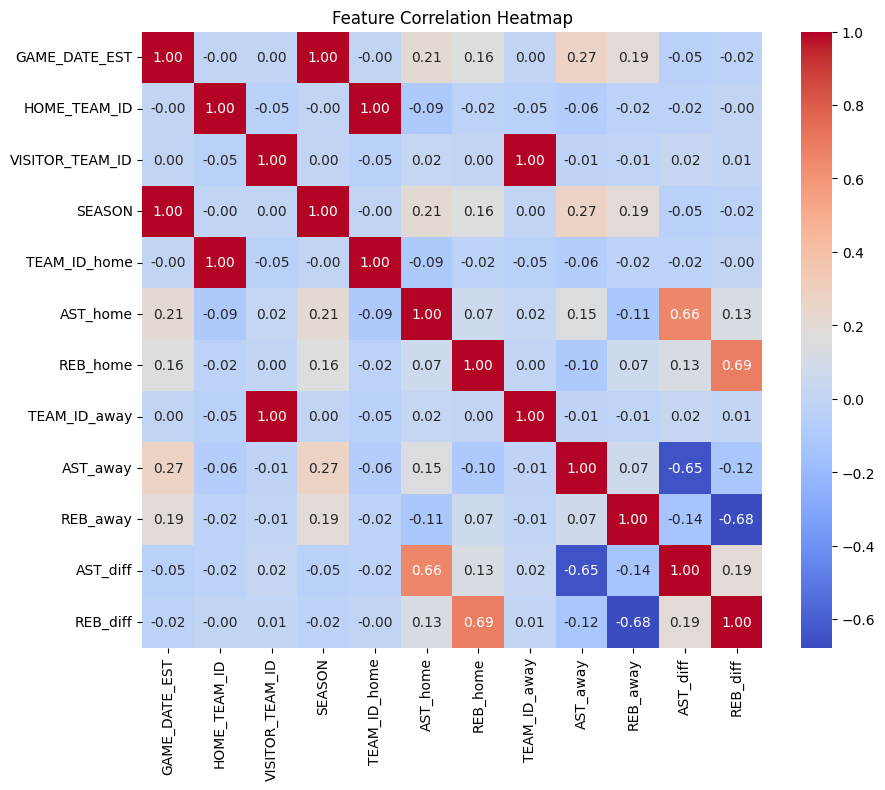

Feature Correlation Heatmap:

The heatmap above displays the correlation between different features used in the model. Highly correlated features might contribute similar information, which can be used for further feature selection.


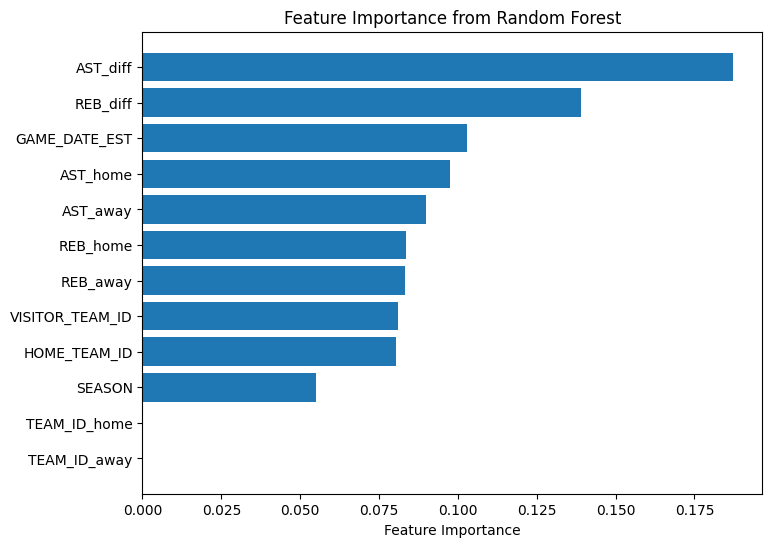

Feature Importance Visualization:

The above image displays the importance of each feature in predicting NBA game outcomes. Features with higher bars contribute more significantly to the prediction model. Key metrics such as team assists and rebounds play a major role in determining the winning probability.


In [131]:
# Visualizing Model Performance & Results

# Baseline Model
baseline_preds = np.ones_like(y_test)
baseline_acc = accuracy_score(y_test, baseline_preds)
print(f"Baseline Accuracy (Always Predict Home Win): {baseline_acc:.4f}")

# Feature Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(X.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

print("Feature Correlation Heatmap:\n")
print("The heatmap above displays the correlation between different features used in the model. Highly correlated features might contribute similar information, which can be used for further feature selection.")

# ROC-AUC Curve
fpr, tpr, _ = roc_curve(y_test, best_rf.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'RF Model (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve")
plt.legend()
plt.show()

# Feature Importance Graph
random_forest.fit(X_train, y_train)
feature_importances = best_rf.feature_importances_
features = X.columns
sorted_indices = np.argsort(feature_importances)

plt.figure(figsize=(8,6))
plt.barh(range(len(sorted_indices)), feature_importances[sorted_indices], align='center')
plt.yticks(range(len(sorted_indices)), [X.columns[i] for i in sorted_indices])
plt.xlabel("Feature Importance")
plt.title("Feature Importance in Random Forest")
plt.show()

print("Feature Importance Visualization:\n")
print("The above image displays the importance of each feature in predicting NBA game outcomes. Features with higher bars contribute more significantly to the prediction model. Key metrics such as team assists and rebounds play a major role in determining the winning probability.")

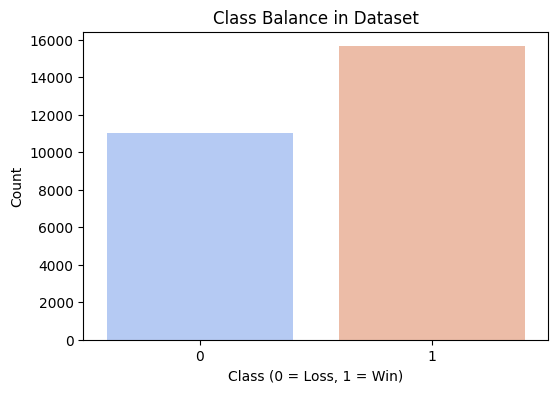

Class Balance Visualization:

This plot shows the distribution of wins and losses in the dataset. A balanced dataset is crucial for a fair prediction model.


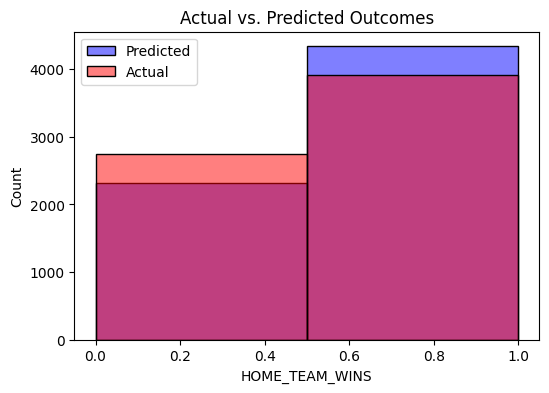

Actual vs Predicted Outcomes:

The histogram compares the model's predicted results with the actual outcomes, providing insights into prediction accuracy and potential misclassifications.


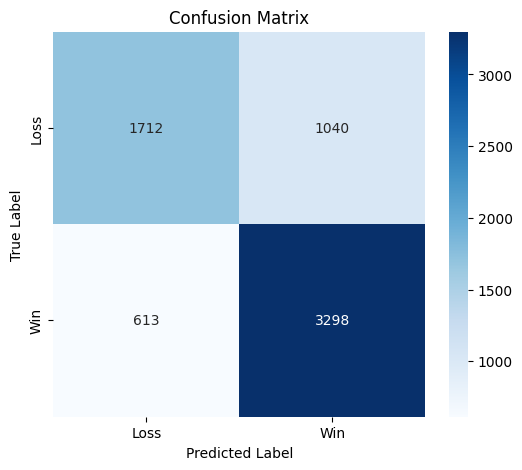

Confusion Matrix Explanation:

The confusion matrix illustrates the accuracy of the model by comparing actual vs. predicted game outcomes. The diagonal values represent correctly predicted games, while off-diagonal values indicate misclassifications.
Cross-Validation Scores: [0.72969424 0.73283302 0.71801126 0.71763602 0.73977486]
Mean Cross-Validation Accuracy: 0.7275898801410421


In [132]:

# Class Balance in Dataset
plt.figure(figsize=(6, 4))
sns.countplot(x=y, hue=y, palette="coolwarm", legend=False)
plt.xlabel("Class (0 = Loss, 1 = Win)")
plt.ylabel("Count")
plt.title("Class Balance in Dataset")
plt.show()

print("Class Balance Visualization:\n")
print("This plot shows the distribution of wins and losses in the dataset. A balanced dataset is crucial for a fair prediction model.")

# Actual vs Predicted Outcomes
plt.figure(figsize=(6, 4))
sns.histplot(y_pred, color="blue", label="Predicted", alpha=0.5, bins=2)
sns.histplot(y_test, color="red", label="Actual", alpha=0.5, bins=2)
plt.legend()
plt.title("Actual vs. Predicted Outcomes")
plt.show()

print("Actual vs Predicted Outcomes:\n")
print("The histogram compares the model's predicted results with the actual outcomes, providing insights into prediction accuracy and potential misclassifications.")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Loss", "Win"], yticklabels=["Loss", "Win"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

print("Confusion Matrix Explanation:\n")
print("The confusion matrix illustrates the accuracy of the model by comparing actual vs. predicted game outcomes. The diagonal values represent correctly predicted games, while off-diagonal values indicate misclassifications.")

# Cross-Validation Evaluation
cv_scores = cross_val_score(voting_model, X, y, cv=5, scoring='accuracy', n_jobs=-1)
print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Accuracy:", cv_scores.mean())